In [1]:
def generate_points():
    n_samples = 100
    n_clusters = 3
    centers = [(-5, -5), (0, 0), (5, 5)]
    cluster_std = 0.5

    # Generate points for each cluster
    points = []
    labels = []

    for i, center in enumerate(centers):
        x = np.random.normal(center[0], cluster_std, n_samples // n_clusters)
        y = np.random.normal(center[1], cluster_std, n_samples // n_clusters)
        cluster_points = np.column_stack((x, y))
        points.append(cluster_points)
        labels.append(np.full(n_samples // n_clusters, i))

    points = np.vstack(points)
    labels = np.concatenate(labels)

    df = pd.DataFrame(points, columns=['Feature1', 'Feature2'])
    df['Label'] = labels
    df_sorted = df.sort_values(by=['Feature1', 'Feature2']).reset_index(drop=True)

    X = df_sorted[['Feature1', 'Feature2']].values
    GT = df_sorted['Label'].values

    # plt.scatter(X[:, 0], X[:, 1], c=GT, cmap='viridis')
    # plt.title('Generated and Sorted Points')
    # plt.xlabel('Feature1')
    # plt.ylabel('Feature2')
    # plt.show()

    return X, GT

GRID SIZE:  10
Data shape: (99, 2)
GT shape (99,)
(99,)
Initialized with NEigs = 100 (type: <class 'int'>)
Pairwise Distance Matrix:
[[ 0.          0.61616237  0.65640799 ... 15.67570232 16.70662338
  16.06517563]
 [ 0.61616237  0.          0.06236726 ... 15.3173295  16.37951027
  15.70942207]
 [ 0.65640799  0.06236726  0.         ... 15.33605369 16.40179728
  15.72843282]
 ...
 [15.67570232 15.3173295  15.33605369 ...  0.          1.43223745
   0.39930923]
 [16.70662338 16.37951027 16.40179728 ...  1.43223745  0.
   1.11795034]
 [16.06517563 15.70942207 15.72843282 ...  0.39930923  1.11795034
   0.        ]]
Transition Matrix:
[[0.         0.00706012 0.11566579 ... 0.         0.         0.        ]
 [0.03592459 0.         0.01705958 ... 0.         0.         0.        ]
 [0.02222649 0.01296555 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.1405357 ]
 [0.         0.         0.         ... 0.         0.         0.0161

/Users/seoli/Desktop/DIAMONDS/Tufts2024/lund/utils.py:138: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  eigvals, eigvecs = eigs(P, k = n_eigs)


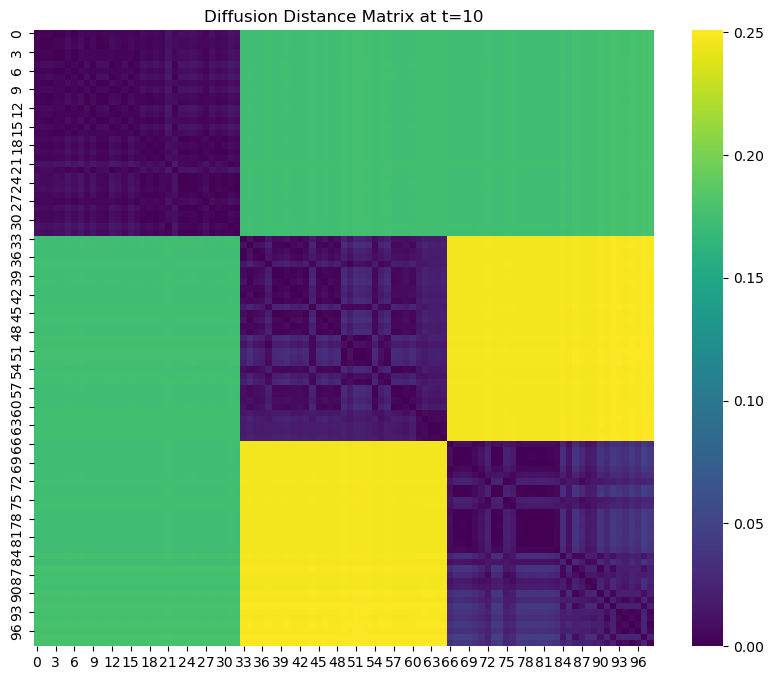

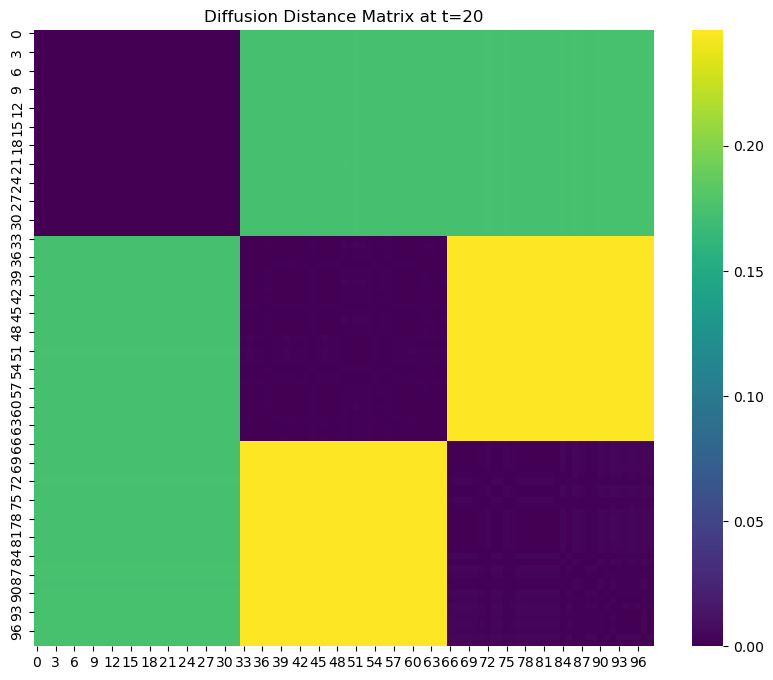

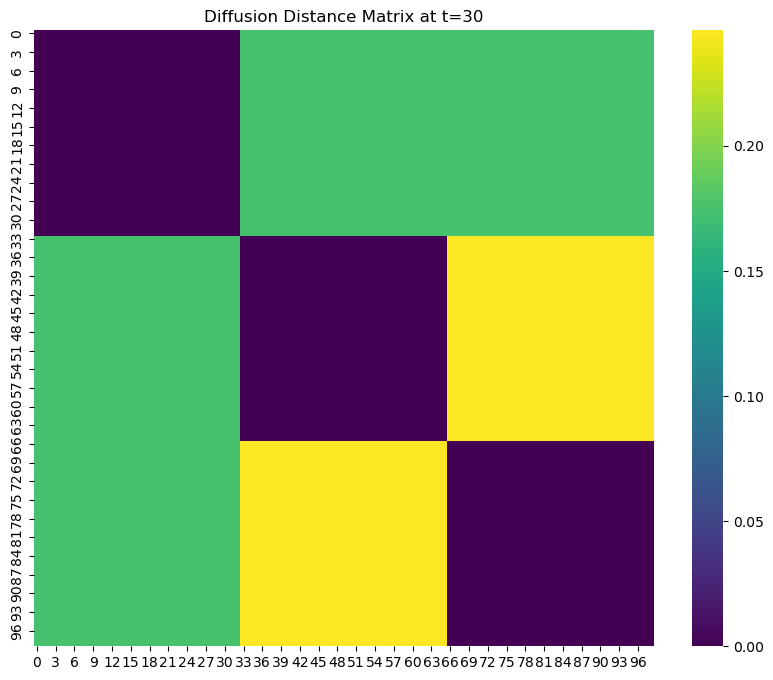

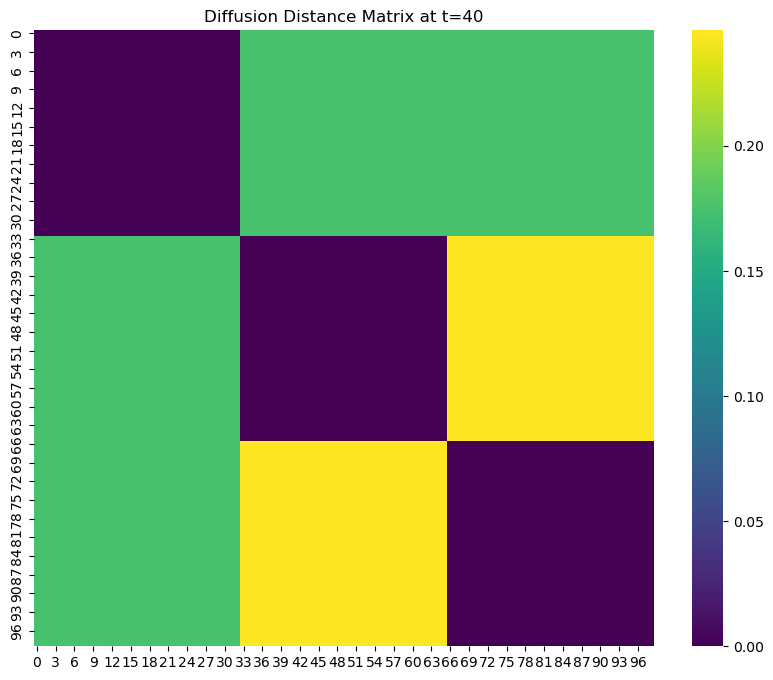

entered lund
Number of Eigenvalues: 99
Number of Eigenvectors: (99, 99)
99
Shape of G['EigenVecs']: (99, 99)
Shape of G['EigenVals']: (99,)
m_sorting: [14 47 83 87 88 91 86 93 55 76 85 71 75 84 70 56 92 89 61 82 97 62 94 45
 95 36 66 59 44 52 42 37 90 40 73 72 58 63 77 74 96 48 38 57 51 65 64 80
 46 67 33 35 41 79 60 50 53 19 34 16 81 39 69 13 54 24 98 49  9 31 68 25
 78 18 26 29  7 21 15 17 28  1 23  6  8 11 27 12 43  4  3 30 22  0 10 20
 32  2  5]
Number of clusters K: 3
Number of clusters: 3
Aligned Accuracy: 1.0


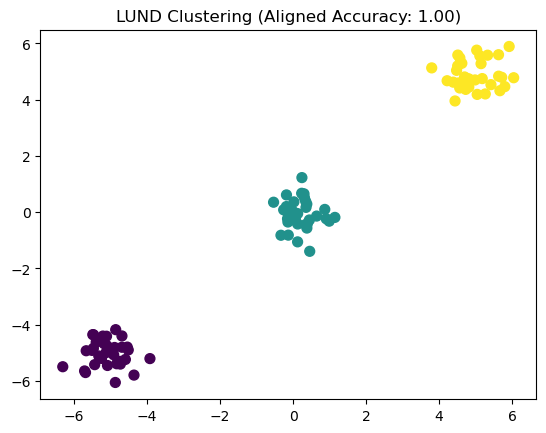

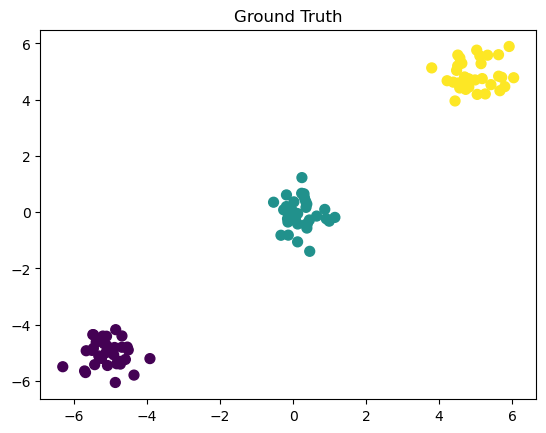

In [3]:
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.datasets import make_moons, make_blobs, make_classification, make_circles
from sklearn.manifold import TSNE
from scipy.sparse.csgraph import laplacian
from scipy.spatial.distance import pdist, squareform
from lund.lund import LearningbyUnsupervisedNonlinearDiffusion
from lund.utils import GraphExtractor, diffusion_distance
from model.utils import loadHSI,calculate_aligned_accuracy
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd

# data_path, gt_path, data_name, gt_name = '/Users/seoli/Desktop/DIAMONDS/Tufts2024/data/SalinasA_corrected.mat', '/Users/seoli/Desktop/DIAMONDS/Tufts2024/data/SalinasA_gt.mat', 'salinasA_corrected', 'salinasA_gt'


# X, M, N, D, HSI, GT, Y, n, K = loadHSI(data_path, gt_path, data_name, gt_name)
X,GT = generate_points()

scipy.io.savemat('data.mat', {'X': X, 'GT': GT})

grid_size = int(np.ceil(np.sqrt(X.shape[0])))
print("GRID SIZE: ", grid_size)

print("Data shape:", X.shape)
print("GT shape", GT.shape)
# GT = GT - 1
# HSI = X.reshape((M, N, D))
# Hyperparameters = {
#     'Sigma': 1.0,
#     'DiffusionNN': 10,
    
# }

kde = KernelDensity(bandwidth=1.0)
kde.fit(X)
log_density = kde.score_samples(X)
p = np.exp(log_density)
print(p.shape)
graph_extractor = GraphExtractor(sigma = 0.5, DiffusionNN = 10)
G = graph_extractor.extract_graph(X)


def plot_diffusion_distance(G, timestep):

    distances, embedding = diffusion_distance(G, timestep)
    plt.figure(figsize=(10, 8))
    sns.heatmap(distances, cmap='viridis')
    plt.title(f'Diffusion Distance Matrix at t={timestep}')
    plt.show()


for timestep in [10, 20, 30, 40]:
    plot_diffusion_distance(G, timestep)

C, K, Dt = LearningbyUnsupervisedNonlinearDiffusion(X, 30, G, p)


# print("Cluster labels:", C)
# print("GT",GT)
print("Number of clusters:", K)

accuracy = calculate_aligned_accuracy(GT, C)
print("Aligned Accuracy:", accuracy)

def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.show()
    
def plot_kde_density(X, title):
    # Create the KDE plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=X[:, 0], y=X[:, 1], cmap='viridis', fill=True, levels=20, thresh=0)
    plt.scatter(X[:, 0], X[:, 1], c='red', s=5, edgecolor='k')
    plt.title(title)
    plt.show()


plot_clusters(X, C, f"LUND Clustering (Aligned Accuracy: {accuracy:.2f})")
plot_clusters(X, GT, "Ground Truth")
# plot_kde_density(X, "KDE Density Estimation")

# kmeans = KMeans(n_clusters=2, random_state=42)
# kmeans_labels = kmeans.fit_predict(X)
# kmeans_accuracy = calculate_aligned_accuracy(GT, kmeans_labels)
# print("Aligned Accuracy (KMeans Clustering):", kmeans_accuracy)
# plot_clusters(X, kmeans_labels, f"KMeans Clustering (Aligned Accuracy: {kmeans_accuracy:.2f})")


